# Flappy Bird Reinforcement Learning

Flappy Bird is one of the most popular and iconic mobile game ever, with its massive popularity boom back in 2014. The game had everyone stuck to their phone screens tapping away for hours trying to set new high scores. The objective of the game was simple, to survive as long as possible without hitting the obstacles. Doing this however was not so simple. Getting a high score in flappy would take not only a huge amount of focus, but also a lot of time. However, because of its simplicity, and the fact that the game can go on forever, it seems like the perfect game to test out the limits of AI. Our project is to train an AI model using reinforcement learning to learn how to play the game and achieve the highest score possible.  

# Data Sources

The unautomated base game of flappy bird was taken from LeonMarqs's repository  https://github.com/LeonMarqs/Flappy-bird-python/tree/master, who credited  https://github.com/zhaolingzhi/FlapPyBird-master for the game_assets such as the images and sounds. We decided to use an external repository for the game, so that we would not have to build flappy bird from scratch. The goal of the project was not to build a game, but to automate the work of playing the game.

# Reinforcement Learning Tasks

There were several parts of creating a deep Q network for flappy bird
1. Setting up a working game environment such that it would be compatible with the agent, and provide the game state on request
2. Defining the constraints and parameters of the main and target network
3. Setting up the agent, so that it would be able to interact with the game environment by either jumping or not jumping on command
4. Training the networks, by having the agent play the game and using a mix of exploration and exploitation to provide new data  
5. Testing the network and evaluating results through use of a purely exploratory stage
6. Finetuning parameters

# Network Setup & Exploratory Analysis

For our final model of the network we had
* The input layer, taking in 4 inputs (bird_height, pipe_x_pos, top_pipe_y_pos, bottom_pipe_y_pos)
* 2 Fully connected layers, both of 32 nodes
* The output layer, with 2 nodes indicating whether or not to jump
	
The data was taken from the game at every tick and fed through the network, alongside the action and reward that was observed. The network used 2 relu functions, a mean-squared error loss function, and an adam optimiser to exploit for it's speed. 

Other concepts included the use of a modified q value calculator : rewards + (1 - dones) * self.gamma for the update of future discounted rewards, taken from https://medium.com/@www.seymour/training-an-ai-to-play-a-game-using-deep-reinforcement-learning-b63534cfdecd. 

# Models and/or Methods



The members of our group were all fairly new to machine learning, hence we did a lot of research into various methods and implementations to compensate for our lack in knowledge. Admittedly we started off undirected and were overwhelmed by the concept of deep q learning, with the strategy of tackling problems that came our way one by one. 

Thanks to recommendation made by the tutor after our first meeting, we had a more cohesive understanding of Deep Q learning, and we directed focus into researching what our tutor had mentioned, such as double and duelling DQN's for environments.

However since we had already built a foundation at that point, we wanted to continue testing our hypothesis. From our understanding double and duelling DQN's would make training faster by reducing the risk of overestimation of q values, however there was no research that indicated that these models would always excel over the simple DQN that we had already started working on. Because of our inexperience, and late head start (due to random group formation) we simply focused on getting a model working, and trivialised training time. We assumed that by passing in larger amounts of data for training, we could reduce the complexity of the model and still achieve a decent accuracy. Additionally, there was much more documentation for simple DQNs on the internet that we could use to help gauge the correctness of our model implementation, hence such is the reasoning behind us choosing a simple DQN model.


# Game Environment Code

In [ ]:
import pygame
import random
import time
from pygame.locals import *

# VARIABLES
SCREEN_WIDTH = 400
SCREEN_HEIGHT = 600
SPEED = 10
GRAVITY = 1
GAME_SPEED = 10

GROUND_WIDTH = 2 * SCREEN_WIDTH
GROUND_HEIGHT = 100

PIPE_WIDTH = 80
PIPE_HEIGHT = 500
PIPE_GAP = 200

wing = 'assets/audio/wing.wav'
hit = 'assets/audio/hit.wav'

def show_score(screen, score, font):
    score_surface = font.render(f'Score: {score}', True, (255, 255, 255))
    screen.blit(score_surface, (SCREEN_WIDTH - score_surface.get_width() - 10, 10))

def game_over_screen(screen, score, score_font):
    """
    Show a game-over screen with the final score and a message to restart.
    """
   #Prompt information for rendering scores and restarting
    score_text = score_font.render(f'Final Score: {score}', True, (255, 255, 255))
    restart_text = score_font.render('Press Space to Restart', True, (255, 255, 255))

   #Display score and prompt information in the center
    score_rect = score_text.get_rect(center=(SCREEN_WIDTH / 2, SCREEN_HEIGHT / 2))
    restart_rect = restart_text.get_rect(center=(SCREEN_WIDTH / 2, SCREEN_HEIGHT / 2 + 50))

    screen.blit(score_text, score_rect)
    screen.blit(restart_text, restart_rect)

    #Update screen display
    pygame.display.update()

    #Waiting for player response
    waiting = True
    while waiting:
        for event in pygame.event.get():
            if event.type == QUIT:
                pygame.quit()
                return False  #End the game
            if event.type == KEYDOWN:
                if event.key == K_SPACE:
                    return True  #Restart the game

def get_random_pipes(xpos):
    size = random.randint(100, 300)
    pipe = Pipe(False, xpos, size)
    pipe_inverted = Pipe(True, xpos, SCREEN_HEIGHT - size - PIPE_GAP)
    return pipe, pipe_inverted

class Bird(pygame.sprite.Sprite):

    def __init__(self):
        pygame.sprite.Sprite.__init__(self)

        self.images =  [pygame.image.load('assets/sprites/bluebird-upflap.png').convert_alpha(),
                        pygame.image.load('assets/sprites/bluebird-midflap.png').convert_alpha(),
                        pygame.image.load('assets/sprites/bluebird-downflap.png').convert_alpha()]

        self.speed = SPEED

        self.current_image = 0
        self.image = pygame.image.load('assets/sprites/bluebird-upflap.png').convert_alpha()
        self.mask = pygame.mask.from_surface(self.image)

        self.rect = self.image.get_rect()
        self.rect[0] = SCREEN_WIDTH / 6
        self.rect[1] = SCREEN_HEIGHT / 2

    def update(self):
        self.current_image = (self.current_image + 1) % 3
        self.image = self.images[self.current_image]
        self.speed += GRAVITY

        #UPDATE HEIGHT
        self.rect[1] += self.speed

    def bump(self):
        self.speed = -SPEED

    def begin(self):
        self.current_image = (self.current_image + 1) % 3
        self.image = self.images[self.current_image]




class Pipe(pygame.sprite.Sprite):

    def __init__(self, inverted, xpos, ysize):
        pygame.sprite.Sprite.__init__(self)

        self. image = pygame.image.load('assets/sprites/pipe-green.png').convert_alpha()
        self.image = pygame.transform.scale(self.image, (PIPE_WIDTH, PIPE_HEIGHT))


        self.rect = self.image.get_rect()
        self.rect[0] = xpos

        if inverted:
            self.image = pygame.transform.flip(self.image, False, True)
            self.rect[1] = - (self.rect[3] - ysize)
        else:
            self.rect[1] = SCREEN_HEIGHT - ysize


        self.mask = pygame.mask.from_surface(self.image)


    def update(self):
        self.rect[0] -= GAME_SPEED

        

class Ground(pygame.sprite.Sprite):
    
    def __init__(self, xpos):
        pygame.sprite.Sprite.__init__(self)
        self.image = pygame.image.load('assets/sprites/base.png').convert_alpha()
        self.image = pygame.transform.scale(self.image, (GROUND_WIDTH, GROUND_HEIGHT))

        self.mask = pygame.mask.from_surface(self.image)

        self.rect = self.image.get_rect()
        self.rect[0] = xpos
        self.rect[1] = SCREEN_HEIGHT - GROUND_HEIGHT
    def update(self):
        self.rect[0] -= GAME_SPEED


class FlappyBirdEnv:
    def __init__(self):
        pygame.init()
        self.screen = pygame.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT))
        pygame.display.set_caption('Flappy Bird')

        self.BACKGROUND = pygame.image.load('assets/sprites/background-day.png').convert()
        self.BACKGROUND = pygame.transform.scale(self.BACKGROUND, (SCREEN_WIDTH, SCREEN_HEIGHT))

        self.wing_sound = pygame.mixer.Sound(wing)  #Preload sound
        self.hit_sound = pygame.mixer.Sound(hit)

        self.score_font = pygame.font.Font(None, 32)
        self.clock = pygame.time.Clock()

        self.score = 0
        self.bird_group = pygame.sprite.Group()
        self.bird = Bird()
        self.ground_group = pygame.sprite.Group()
        self.pipe_group = pygame.sprite.Group()

    def reset(self):
        self.score = 0
        self.bird_group.remove()
        self.pipe_group.remove()
        self.ground_group.remove()

        self.bird_group = pygame.sprite.Group()
        self.bird = Bird()
        self.bird_group.add(self.bird)

        self.ground_group = pygame.sprite.Group()
        for i in range(2):
            ground = Ground(GROUND_WIDTH * i)
            self.ground_group.add(ground)

        self.pipe_group = pygame.sprite.Group()
        for i in range(2):
            pipes = get_random_pipes(SCREEN_WIDTH * i + 800)
            self.pipe_group.add(pipes[0])
            self.pipe_group.add(pipes[1])
        return self.get_observation()

    def step(self, action):
        self.clock.tick(50)

        for event in pygame.event.get():
            if event.type == QUIT:
                pygame.quit()
                return False  #End the game
        
        if action == 1:
            self.bird.bump()
            self.wing_sound.play()

        self.screen.blit(self.BACKGROUND, (0, 0))

        if is_off_screen(self.ground_group.sprites()[0]):
            self.ground_group.remove(self.ground_group.sprites()[0])
            new_ground = Ground(GROUND_WIDTH - 20)
            self.ground_group.add(new_ground)

        if is_off_screen(self.pipe_group.sprites()[0]):
            self.pipe_group.remove(self.pipe_group.sprites()[0])
            self.pipe_group.remove(self.pipe_group.sprites()[0])
            self.score += 1
            pipes = get_random_pipes(SCREEN_WIDTH * 2)
            self.pipe_group.add(pipes[0])
            self.pipe_group.add(pipes[1])

        self.bird_group.update()
        self.ground_group.update()
        self.pipe_group.update()

        self.bird_group.draw(self.screen)
        self.pipe_group.draw(self.screen)
        self.ground_group.draw(self.screen)

        show_score(self.screen, self.score, self.score_font)

        pygame.display.update()
        
        if (pygame.sprite.groupcollide(self.bird_group, self.ground_group, False, False, pygame.sprite.collide_mask) or
                pygame.sprite.groupcollide(self.bird_group, self.pipe_group, False, False, pygame.sprite.collide_mask)):
            self.hit_sound.play()
            observation = self.get_observation(), -100, 1
            print(self.score)
            #self.reset()
            time.sleep(1)  #Pause briefly to display collision effects
            return observation
        return self.get_observation(), 0, 0

    def get_observation(self):
        return automatic_play(self.bird, self.pipe_group)

def automatic_play(bird, pipe_group):
    bird_height = bird.rect[1]
    if (pipe_group.sprites()[0].rect[0] < 0):
        pipe_x_pos = pipe_group.sprites()[2].rect[0]
        top_pipe_y_pos = pipe_group.sprites()[2].rect[1]
        bottom_pipe_y_pos = pipe_group.sprites()[3].rect[1]
    else:
        pipe_x_pos = pipe_group.sprites()[0].rect[0]
        top_pipe_y_pos = pipe_group.sprites()[0].rect[1]
        bottom_pipe_y_pos = pipe_group.sprites()[1].rect[1]
    return (bird_height, pipe_x_pos, top_pipe_y_pos, bottom_pipe_y_pos)

def is_off_screen(sprite):
    return sprite.rect[0] < -(sprite.rect[2])

# Agent Code

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import deque
import random
from flappy_RI import FlappyBirdEnv
import os

################# QNET COMPLETE ######################

class QNet(nn.Module):
    def __init__(self, input_dim, f1_dim, f2_dim, output_dim):
        super(QNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, f1_dim)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(f1_dim, f2_dim)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(f2_dim, output_dim)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x


################# AGENT ######################
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.DQN = QNet(state_size, 32, 32, action_size)
        self.target_net = QNet(state_size, 32, 32, action_size)
        self.target_net.load_state_dict(self.DQN.state_dict())
        self.optimizer = optim.Adam(self.DQN.parameters(), lr=0.001)
        self.replay_buffer = deque(maxlen=10000)
        self.gamma = 0.99  # Discount factor
        self.epsilon = 1  # Initial exploration rate
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.001

    def select_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randint(0, 20) > 18  # Explore
        else:
            q_values = self.DQN(torch.FloatTensor(state))
            return torch.argmax(q_values).item()  # Exploit

    def remember(self, state, action, reward, next_state, done):
        self.replay_buffer.append((state, action, reward, next_state, done))

    def experience_replay(self, batch_size):
        if len(self.replay_buffer) < batch_size:
            return

        minibatch = random.sample(self.replay_buffer, batch_size)
        states, actions, rewards, next_states, dones = map(list, zip(*minibatch))

        # Convert lists to PyTorch tensors
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)

        q_values = self.DQN(torch.FloatTensor(states))
        next_q_values = self.target_net(torch.FloatTensor(next_states)).max(dim=1).values

        targets = q_values.clone()
        targets[np.arange(batch_size), actions] = rewards + (1 - dones) * self.gamma * next_q_values

        loss = nn.MSELoss()(q_values, targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_net.load_state_dict(self.DQN.state_dict())


################# TRAINING ######################
def train(env, agent, num_episodes, batch_size):
    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0

        while True:
            action = agent.select_action(state)
            next_state, reward, done = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            agent.experience_replay(batch_size)

            total_reward += reward
            state = next_state

            if done:
                break

        agent.update_target_network()

        # Decay exploration rate
        agent.epsilon = max(agent.epsilon * agent.epsilon_decay, agent.epsilon_min)

        # Print episode information
        print(f"Episode: {episode + 1}, Total Reward: {total_reward}")

################# Autoplay ######################
def play(env, agent):
    state = env.reset()
    agent.epsilon = 0
    while True:
        action = agent.select_action(state)
        state, reward, done = env.step(action)

        if done:
            break


################# MAIN ######################
save_data = True
train_model = False

# define the state_size and action_size based on environment
state_size = 4
action_size = 2
agent = DQNAgent(state_size, action_size)

if os.path.exists("pre_train.pth") and train_model == False:
    # load pretrained weights
    checkpoint = torch.load("pre_train.pth")
    loaded_model = agent.DQN
    loaded_model.load_state_dict(checkpoint['model_state_dict'])

env = FlappyBirdEnv()
batch_size = 15
if train_model == True:
    train(env, agent, 350, batch_size)
else:
    for i in range(1,10):
        play(env, agent)

if save_data == True and train_model == True:
    checkpoint_path = 'pre_train.pth'
    torch.save({'model_state_dict': agent.DQN.state_dict(),
                'target_model_dict': agent.target_net.state_dict(),
                'optimizer_state_dict': agent.optimizer.state_dict(),
                'replay_buffer': list(agent.replay_buffer),
                'gamma': agent.gamma,
                'epsilon': agent.epsilon,
                'epsilon_decay': agent.epsilon_decay
                }, checkpoint_path)

# Results


When training the model, we tried out several different values for the parameters such as the number of of epochs, number of nodes in the hidden layer, the batch sie, learning rate and clock speed.  Below are the results of the values that we tried.



 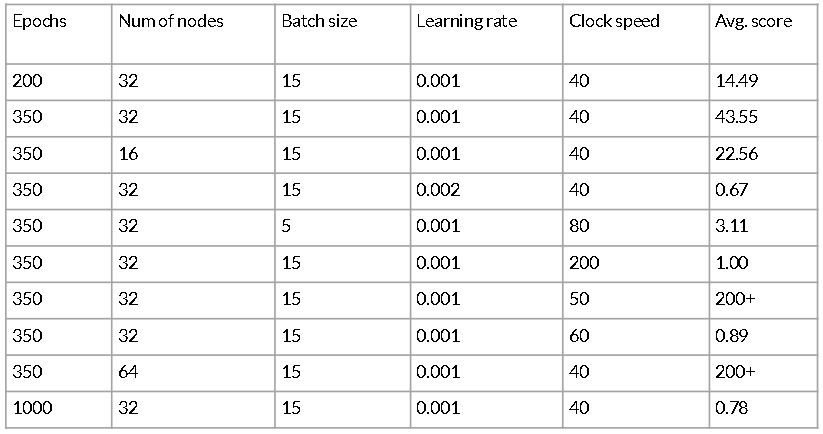

As we can see from the table, when we tried changing values for the learning rate and batch size, but the average score was drasitically reduced. This meant that these values were very sensitive to the outcome and we decided not to tinker with them much after the first attempt. After increasing the clocksize by a huge amount, we realized that small changes to this parameter would be a better choice. We also found that the sweet spot for the number of epochs was 350, as too many epochs would output a much worse average score. The best results of these test came out from a combination of 350 epochs, 15 batch size, and 0.01 learning rate, with a results of 200+ score. 200+ score in the tables here actually mean that they were able to achieve a state where it could go infinitely.


# Conclusion


In the end, our model was able to successfully learn to play the game to a level which resulted in an infinite score, however the training process for these kinds of results took quite a lot of time. There are several areas where we think could be improved in the model to enhance the speed and learning rate. First, we think that a convolutional network as the DQ network would allow for the agent to learn in a faster manner, reaching higher scores with less training time. Giving the agent more input parameters could also aid the agent in recognising specific patterns of when to jump, thus effectively enhancing the training the process, but a balance must be struck such that the network isn't overwhelmed with unnecessary inputs that would only hinder the agent from learning.

In conclusion, although only one of our three attempted models produced anything, we were happy with the results of the one even if the training took quite a long time.